In [34]:
## load PFCLM output and compare to Ameriflux data

import parflow as pf
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from glob import glob
import pandas as pd
import parflow as pf
from pathlib import Path

from parflow import Run
import parflow.tools.hydrology as hydro


import hf_hydrodata as hf

# swap to your email and PIN
## [register PIN here](https://hydrogen.princeton.edu/pin)
#hf.gridded.register_api_pin("<your_email>", "<your_pin>")


In [41]:

# set the path to the data and the date range
start = "2018-10-01"
end = "2019-10-01"
static_write_dir = "/Users/reed/Projects/ParFlow_example_cases/single_column_ET"
base = static_write_dir 
site_id = 'US-Ne2'

print('working directory: ', base)

# get info and metadata for the Ameriflux site we are interested in comparing to
data_set = "ameriflux"
variable = 'latent_heat'
temporal_resolution = 'hourly'
aggregation = 'sum'

metadata_df = hf.get_point_metadata(dataset =  data_set, variable =variable, temporal_resolution =  temporal_resolution, aggregation =aggregation,site_ids=site_id)
metadata_df.head(5)


working directory:  /Users/reed/Projects/ParFlow_example_cases/single_column_ET


,site_id,site_name,site_type,agency,state,latitude,longitude,first_date_data_available,last_date_data_available,record_count,...,ameriflux_mean_annual_precip,ameriflux_team_member_name,ameriflux_team_member_role,ameriflux_team_member_email,ameriflux_team_member_institution,ameriflux_site_funding,ameriflux_acknowledgement,ameriflux_acknowledgement_comment,ameriflux_doi_citation,ameriflux_alternate_url
0,US-Ne2,Mead - irrigated maize-soybean rotation site,flux tower,AmeriFlux,NE,41.1649,-96.4701,2001-01-01,2021-01-01,175320,...,788.89,"Andy Suyker, Dan Hatch","PI, DataManager","asuyker1@unl.edu, dhatch2@unl.edu","University of Nebraska - Lincoln, University o...",DOE (OBER & EPSCoR),None,None,"Andy Suyker (2023), AmeriFlux BASE US-Ne2 Mead...",http://csp.unl.edu/public/


In [42]:

# load in the run information from the PFIDB file
run_name = 'pfclm_sc'
run = Run.from_definition(f'{base}/{run_name}.pfidb')
data = run.data_accessor
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz


# intialize data and time arrays
data    = np.zeros([8,8760])
time    = np.zeros([8760])

#CLM data array format 
# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0 eflx_lh_tot:  total latent heat flux (Wm-2)  
# 1 eflx_lwrad_out: total upward LW radiation (Wm-2)  
# 2 eflx_sh_tot: total sensible heat flux (Wm-2)  
# 3 eflx_soil_grnd: ground heat flux (Wm-2)    
# 4 qflx_evap_tot: net veg. evaporation and transpiration and soil evaporation (mms-1)  
# 5 qflx_evap_grnd: ground evaporation (mms-1)   
# 6 qflx_evap_soi: soil evaporation (mms-1)   
# 7 qflx_evap_veg: vegetation evaporation (canopy) and transpiration (mms-1)   
# 8 qflx_tran_veg: transpiration (mms-1)  
# 9 qflx_infl: infiltration flux (mms-1)   
# 10 swe_out: SWE (mm)   
# 11 t_grnd: ground temperature (K)  
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)

file_in = base+"/PFCLM_SC.out.00001.nc"
print(file_in)
pf_out = xr.open_mfdataset(file_in)
print(pf_out.head())

file_in = base+"/PFCLM_SC.out.CLM.00001.nc"
print(file_in)
clm_out = xr.open_mfdataset(file_in)
print(clm_out.head())


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
/Users/reed/Projects/ParFlow_example_cases/single_column_ET/PFCLM_SC.out.00001.nc
<xarray.Dataset> Size: 440B
Dimensions:     (time: 5, z: 5, y: 1, x: 1)
Coordinates:
  * time        (time) float64 40B 1.0 2.0 3.0 4.0 5.0
Dimensions without coordinates: z, y, x
Data variables:
    pressure    (time, z, y, x) float64 200B dask.array<chunksize=(1, 5, 1, 1), meta=np.ndarray>
    saturation  (time, z, y, x) float64 200B dask.array<chunksize=(1, 5, 1, 1), meta=np.ndarray>
/Users/reed/Projects/ParFlow_example_cases/single_column_ET/PFCLM_SC.out.CLM.00001.nc
<xarray.Dataset> Size: 640B
Dimensions:         (time: 5, y: 1, x: 1, z: 3)
Coordinates:
  * time            (time) float64 40B 1.0 2.0 3.0 4.0 5.0
Dimensions without coordinates: y, x, z
Data variables: (12/13)
    eflx_lh_tot     (time, y, x) float64 40B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    eflx_lwrad_out  (time, y, x) float64 40B dask.array<chunks

/Users/reed/miniforge3.1/envs/subsettools/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


In [43]:

# load the forcing file into a Pandas dataframe

# load forcing, single column, variables are
#DSWR:  Downward Visible or Short-Wave radiation [W/m2]
#DLWR:  Downward Infa-Red or Long-Wave radiation [W/m2]
#APCP:  Precipitation rate [mm/s]
#Temp:  Air temperature [K]
#UGRD:  West-to-East or U-component of wind [m/s]
#VGRD:  South-to-North or V-component of wind [m/s]
#Press: Atmospheric Pressure [pa]
#SPFH:  Water-vapor specific humidity [kg/kg]

# load the forcing file into a Pandas dataframe
# we could load this file directly, as is shown in the commented-out line, but we can also
# use the key database and load it dynamically as shown

file = base+'/'+run.Solver.CLM.MetFileName
print(file)

# 1D forcing files are text columns not technically CSVs but this is an easy 
# way to load
forcing_df = pd.read_csv(file,sep=' ',header=None,engine='python') 
# add PF-CLM variable names and units 
forcing_df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]
print(forcing_df.head())



/Users/reed/Projects/ParFlow_example_cases/single_column_ET/forcing1D.US-Ne2.2018-10-01-2019-10-01.txt
   DSWR [W/m2]  DLWR [W/m2]  APCP [mm/s]    Temp [K]  UGRD [m/s]  VGRD [m/s]  \
0     2.953182   309.072052     0.000075  286.529022   -2.585190   -0.931906   
1     0.000000   308.939484     0.000132  285.345917   -2.359078   -1.457381   
2     0.000000   311.984619     0.000074  284.160400   -2.136089   -1.983453   
3     0.000000   318.191498     0.000054  282.977936   -1.915565   -2.514517   
4     0.000000   318.158081     0.000128  282.667664   -1.851054   -2.658537   

     Press [pa]  SPFH [kg/kg]  
0  97782.070312      0.007778  
1  97776.968750      0.007483  
2  97771.828125      0.007189  
3  97766.703125      0.006896  
4  97744.554688      0.006862  


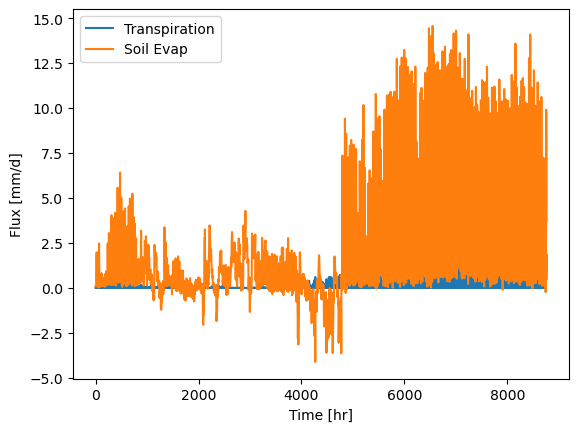

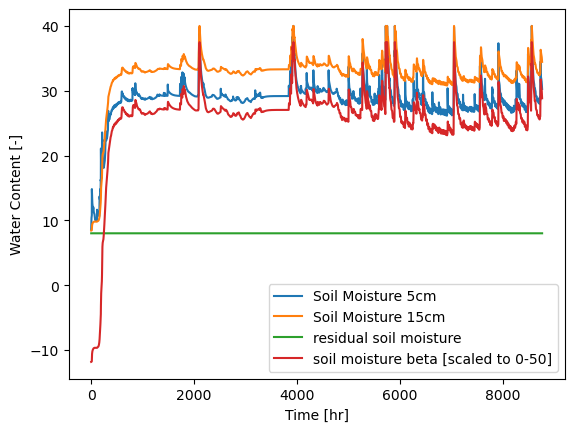

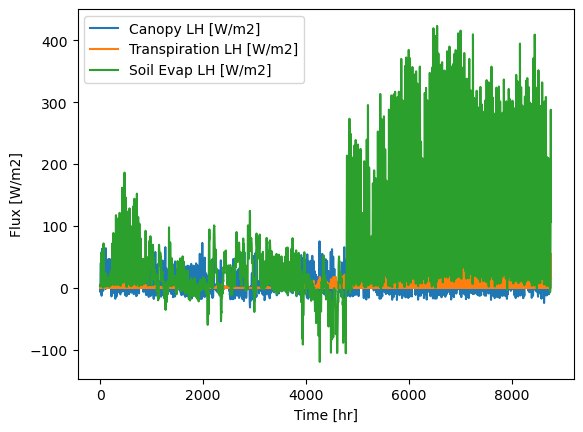

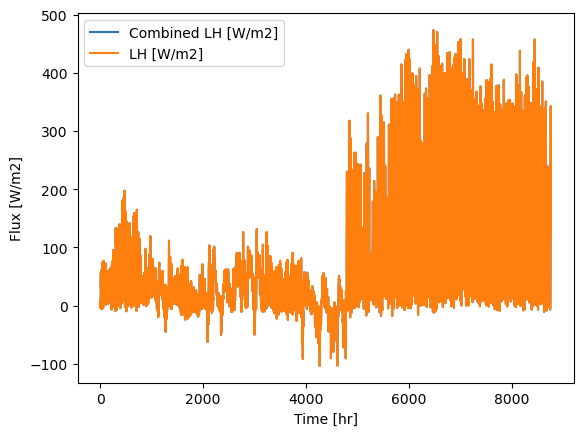

In [44]:
## make a plot of the output from the PFCLM run

res_sat = np.zeros(8760)
res_sat[:] = run.Solver.CLM.ResSat
porosity = run.Geom.domain.Porosity.Value

hvap   = 2.5104e06 #Latent heat of evap for water [J/kg]

# Plot the transpiration and soil evaporation for our PFCLM run

plt.plot(clm_out['qflx_tran_veg'][:,0,0]*(3600*24), label='Transpiration')
plt.plot(clm_out['qflx_evap_soi'][:,0,0]*(3600*24), label='Soil Evap')
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [mm/d]')  ## note that we converted the fluxes to mm/d
plt.legend()
plt.show()

# Plot the soil moisture for our PFCLM run
plt.plot(pf_out['saturation'][:,9,0,0]*100*porosity, label='Soil Moisture 5cm') 
plt.plot(pf_out['saturation'][:,8,0,0]*100*porosity, label='Soil Moisture 15cm') 
plt.plot(res_sat*100*porosity, label='residual soil moisture')
beta = (pf_out['saturation'][:,8,0,0]*50*porosity-res_sat*100*porosity)/(porosity*100-res_sat*100*porosity)
plt.plot(beta*100, label='soil moisture beta [scaled to 0-50]')
plt.xlabel('Time [hr]')  
plt.ylabel('Water Content [-]')  
plt.legend()
plt.show()

# convert the Transipration and Soil Evaporation to W/m2
# note that we are using the latent heat of vaporization for water
plt.plot(clm_out['qflx_evap_veg'][:,0,0]*hvap, label='Canopy LH [W/m2]')
plt.plot(clm_out['qflx_tran_veg'][:,0,0]*hvap, label='Transpiration LH [W/m2]')
plt.plot(clm_out['qflx_evap_soi'][:,0,0]*hvap, label='Soil Evap LH [W/m2]')
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [W/m2]')  ## note that we converted to energy fluxes
plt.legend()
plt.show()

# convert the Transipration and Soil Evaporation to W/m2
# note that we are using the latent heat of vaporization for water
plt.plot(clm_out['qflx_evap_veg'][:,0,0]*hvap+clm_out['qflx_evap_soi'][:,0,0]*hvap, label='Combined LH [W/m2]')

plt.plot(clm_out['eflx_lh_tot'][:,0,0], label='LH [W/m2]')
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [W/m2]')  ## note that we converted to energy fluxes
plt.legend()
plt.show()

In [45]:
# Get data for our Ameriflux site
data_df = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,
                  date_end=end, site_ids=site_id)

data_df.head(5)

,date,US-Ne2
0,2018-10-01 00:00:00,23.5
1,2018-10-01 01:00:00,10.9
2,2018-10-01 02:00:00,-3.4
3,2018-10-01 03:00:00,11.5
4,2018-10-01 04:00:00,16.7


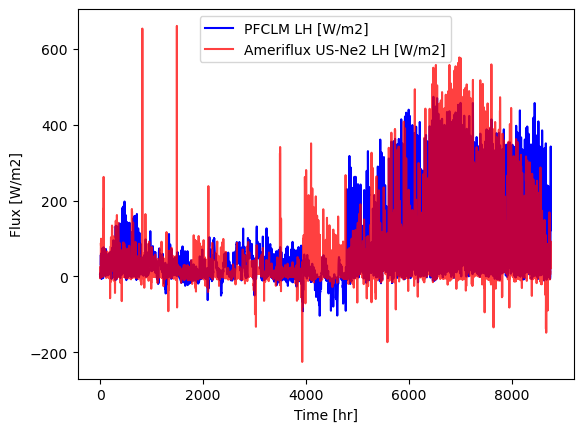

In [57]:
# Plot LH flux our Ameriflux site and our PFCLM run
plt.plot(clm_out['eflx_lh_tot'][:,0,0], label='PFCLM LH [W/m2]',color='blue') 
plt.plot(data_df[site_id], label='Ameriflux '+site_id+' LH [W/m2]',alpha=0.75,color='red') 
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [W/m2]')  
plt.legend()
plt.show()

In [47]:
## now we can do some error checking, for example we can pull the solar radiation from the forcing file and compare it to the Ameriflux data

# Get data for our Ameriflux site
# get info and metadata for the Ameriflux site we are interested in comparing to
data_set = "ameriflux"
variable = 'downward_shortwave'
temporal_resolution = 'hourly'
aggregation = 'mean'


Ameriflux_DSW = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,date_end=end, site_ids=site_id)

Ameriflux_DSW.head(5)


,date,US-Ne2
0,2018-10-01 00:00:00,0.0
1,2018-10-01 01:00:00,0.0
2,2018-10-01 02:00:00,0.0
3,2018-10-01 03:00:00,0.0
4,2018-10-01 04:00:00,0.0


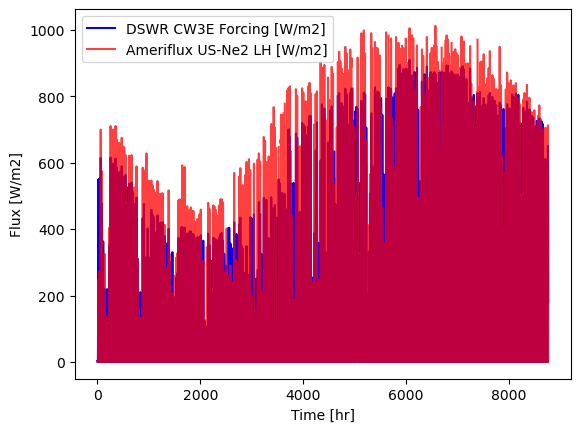

In [55]:

plt.plot(forcing_df["DSWR [W/m2]"], label='DSWR CW3E Forcing [W/m2]',color='blue')
plt.plot(Ameriflux_DSW[site_id], label='Ameriflux '+site_id+' LH [W/m2]',alpha=0.75,color='red')
plt.xlabel('Time [hr]')
plt.ylabel('Flux [W/m2]')
plt.legend()
plt.show()

In [49]:
## now we can check Downward Longwave radiation
variable = 'downward_longwave'
Ameriflux_DLW = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,
                  date_end=end, site_ids=site_id)

Ameriflux_DLW.head(5)


,date,US-Ne2
0,2018-10-01 00:00:00,358.0
1,2018-10-01 01:00:00,357.8
2,2018-10-01 02:00:00,357.7
3,2018-10-01 03:00:00,357.9
4,2018-10-01 04:00:00,358.6


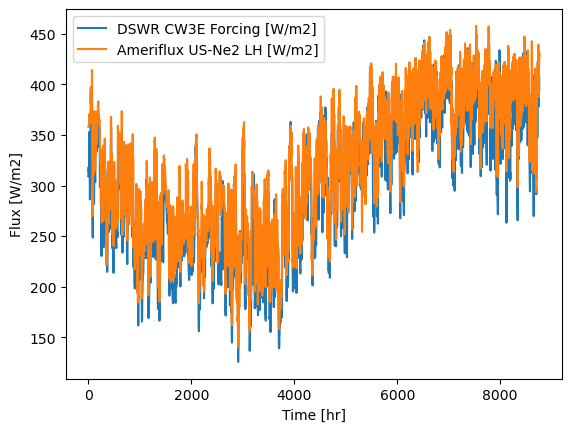

In [50]:
plt.plot(forcing_df["DLWR [W/m2]"], label='DSWR CW3E Forcing [W/m2]')
plt.plot(Ameriflux_DLW[site_id], label='Ameriflux '+site_id+' LH [W/m2]')
plt.xlabel('Time [hr]')
plt.ylabel('Flux [W/m2]')
plt.legend()
plt.show()

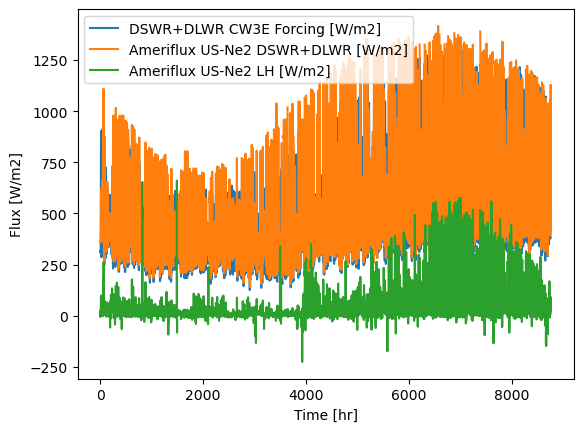

In [51]:
## now we can plot the combined radiation (downward shortwave + downward longwave) and compare to the Ameriflux LH observations
plt.plot(forcing_df["DLWR [W/m2]"]+forcing_df["DSWR [W/m2]"], label='DSWR+DLWR CW3E Forcing [W/m2]')
plt.plot(Ameriflux_DLW[site_id]+Ameriflux_DSW[site_id], label='Ameriflux '+site_id+' DSWR+DLWR [W/m2]')
plt.plot(data_df[site_id], label='Ameriflux '+site_id+' LH [W/m2]') 
plt.xlabel('Time [hr]')
plt.ylabel('Flux [W/m2]')
plt.legend()
plt.show()


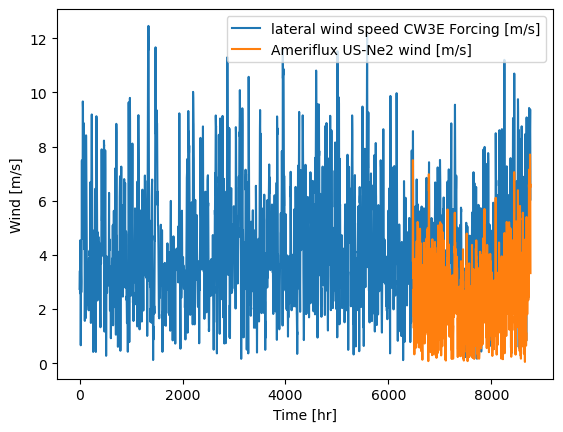

In [52]:

## now we can check the wind speed at the Ameriflux site and compare it to the forcing file
variable = 'wind_speed'
Ameriflux_wind = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,
                  date_end=end, site_ids=site_id)

Ameriflux_wind.head(5)

## now we can plot the combined radiation (downward shortwave + downward longwave) and compare to the Ameriflux LH observations
wind = np.sqrt(forcing_df["UGRD [m/s]"]**2+forcing_df["VGRD [m/s]"]**2)
plt.plot(wind, label='lateral wind speed CW3E Forcing [m/s]')
plt.plot(Ameriflux_wind[site_id], label='Ameriflux '+site_id+' wind [m/s]')
plt.xlabel('Time [hr]')
plt.ylabel('Wind [m/s]')
plt.legend()
plt.show()